In [228]:
import numpy as np
import pandas as pd

In [229]:
import matplotlib.pyplot as plt
%matplotlib inline

In [230]:
df = pd.read_csv('train_clean.csv')

In [231]:
df.head()

,PassengerId,Survived,Pclass,Age,Cabin,Person,Family
0,1,0,3,22,NaN,male,1
1,2,1,1,38,C85,female,1
2,3,1,3,26,NaN,female,0
3,4,1,1,35,C123,female,1
4,5,0,3,35,NaN,male,0


For now, drop Cabin and don't worry about imputation.

In [232]:
del df['Cabin']

Important to remove categorical variables (male, female and child are not on a scale).

From analysis, it seems that Class and Person are categorical. Age can be fitted.

In [233]:
person_df = pd.get_dummies(df['Person'])
class_df = pd.get_dummies(df['Pclass'])
class_df.columns = ['First', 'Second', 'Third']
person_df.columns = ['Child', 'Female', 'Male']

In [234]:
df = pd.concat([df, person_df], axis=1)
df = pd.concat([df, class_df], axis=1)
del df['Person']
del df['Pclass']

df.head()

,PassengerId,Survived,Age,Family,Child,Female,Male,First,Second,Third
0,1,0,22,1,0,0,1,0,0,1
1,2,1,38,1,0,1,0,1,0,0
2,3,1,26,0,0,1,0,0,0,1
3,4,1,35,1,0,1,0,1,0,0
4,5,0,35,0,0,0,1,0,0,1


Need to take care of Multicollinearity from dummy variables.

In [235]:
df = df.drop(['PassengerId', 'Child', 'Third'], axis=1)

In [236]:
df.head()

,Survived,Age,Family,Female,Male,First,Second
0,0,22,1,0,1,0,0
1,1,38,1,1,0,1,0
2,1,26,0,1,0,0,0
3,1,35,1,1,0,1,0
4,0,35,0,0,1,0,0


In [237]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split

In [238]:
log_reg = LogisticRegression()

Take care of NaNs before fitting!

In [239]:
len(df)

891

In [240]:
pd.isnull(df).any()

Survived    False
Age          True
Family      False
Female      False
Male        False
First       False
Second      False
dtype: bool

In [241]:
df = df[df['Age'] < 120]

In [242]:
len(df)

714

In [243]:
df.to_csv('train_clean2.csv', index=False)

In [244]:
pd.isnull(df).any()

Survived    False
Age         False
Family      False
Female      False
Male        False
First       False
Second      False
dtype: bool

In [245]:
Y = df.Survived
Y = np.ravel(Y)
Y[:10]

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1])

In [246]:
df.head()

,Survived,Age,Family,Female,Male,First,Second
0,0,22,1,0,1,0,0
1,1,38,1,1,0,1,0
2,1,26,0,1,0,0,0
3,1,35,1,1,0,1,0
4,0,35,0,0,1,0,0


In [247]:
df = df.drop(['Survived'], axis=1)

In [248]:
log_reg.fit(df, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [249]:
log_reg.score(df, Y)

0.80252100840336138

In [250]:
Y.mean()

0.4061624649859944

40.6% survived, so null error rate is 59.4%. 80.3% is a big increase.

In [251]:
coeff_df = pd.DataFrame(zip(df.columns, np.transpose(log_reg.coef_)))
coeff_df

,0,1
0,Age,[-0.0258036327191]
1,Family,[-0.305428722758]
2,Female,[0.85237675034]
3,Male,[-2.01440370828]
4,First,[2.42355630022]
5,Second,[1.12365026224]


We can say that Third class is least likely to survive in 'Class', (order: 1st > 2nd > 3rd) and that Female is most likely to survive in 'Gender' (order Female > Child > Male). Age is negatively correlated with survival, as seen in Fig. 11, coefficient seems small compared to the rest but note age is a continous variable from 0 to 90, not just 0 or 1. 

In [252]:
X_train, X_test, Y_train, Y_test = train_test_split(df, Y)

### Logistic Regression Model

In [253]:
log_reg = LogisticRegression()

log_reg.fit(X_train, Y_train)

Y_pred = log_reg.predict(X_test)

In [254]:
LR_acc = metrics.accuracy_score(Y_pred, Y_test)
print LR_acc

0.765363128492


### KNN model

In [255]:
from sklearn.neighbors import KNeighborsClassifier

Find peak value for n_neighbors

In [256]:
accuracy = []

for k in range(1,40) :
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, Y_train)
    Y_pred = KNN.predict(X_test)
    accuracy.append(metrics.accuracy_score(Y_pred, Y_test))

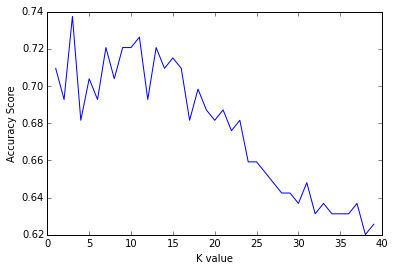

In [257]:
plt.plot(range(1,40), accuracy)
plt.xlabel('K value')
plt.ylabel('Accuracy Score')

In [258]:
K_peak = np.argmax(accuracy) + 1

In [259]:
KNN = KNeighborsClassifier(n_neighbors=K_peak)
KNN.fit(X_train, Y_train)
Y_pred = KNN.predict(X_test)
KNN_acc = metrics.accuracy_score(Y_pred, Y_test)
print KNN_acc

0.737430167598


KNN and Logistic Regression are not much different in accuracy, logistic regression edges it (82.7% vs 78.8%).

### SVC model

In [260]:
from sklearn import svm
# Default 'rbf' is Gaussian
rbf_svc = svm.SVC()
rbf_svc.fit(X_train, Y_train)
Y_pred = rbf_svc.predict(X_test)
metrics.accuracy_score(Y_pred, Y_test)

0.74301675977653636

Again, about 80%. Some different kernels:

In [261]:
lin_svc = svm.SVC(kernel='linear').fit(X_train, Y_train)
pol_svc = svm.SVC(kernel='poly', degree=2).fit(X_train, Y_train)
lin2_svc = svm.LinearSVC().fit(X_train, Y_train)

In [262]:
Y_pred_lin = lin_svc.predict(X_test)
Y_pred_pol = pol_svc.predict(X_test)
Y_pred_lin2 = lin2_svc.predict(X_test)

In [263]:
lin_score = metrics.accuracy_score(Y_pred_lin, Y_test)
pol_score = metrics.accuracy_score(Y_pred_pol, Y_test)
lin2_score = metrics.accuracy_score(Y_pred_lin2, Y_test)

print lin_score, pol_score, lin2_score

0.748603351955 0.759776536313 0.754189944134


None as good as the Gaussian kernel, let's vary C (penalty parameter) and gamma (kernel coefficient) to find an optimum model.

In [264]:
delta = 0.1
Acc_array = []
for i in range(1,20) :
    for j in range(1,20) :
        gam = delta*i
        cc = delta*j
        rbf_svc = svm.SVC(gamma=gam, C=cc)
        rbf_svc.fit(X_train, Y_train)
        Y_pred = rbf_svc.predict(X_test)
        mac = metrics.accuracy_score(Y_pred, Y_test)
        acc_tuple = (gam, cc, mac)
        Acc_array.append(acc_tuple)
        if mac > 0.8 :
            print "gamma= %.1f, C= %.1f, Accuracy Score= %.3f" % (gam, cc, mac)

In [265]:
x, y, z = sorted(Acc_array,key=lambda x: x[2], reverse=True)[0]
SVC_acc = z
print "Best Parameters: Gamma=%.1f, C=%.1f, Accuracy=%.3f" % (x, y, z)

Best Parameters: Gamma=0.1, C=1.6, Accuracy=0.771


### Naive Bayes

In [266]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()

GNB.fit(X_train, Y_train)

GaussianNB()

In [267]:
Y_pred = GNB.predict(X_test)
NB_acc = metrics.accuracy_score(Y_pred, Y_test)
print NB_acc

0.743016759777


### Random Forest

In [268]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=200, min_samples_leaf=2)

RFC.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [269]:
Y_pred = RFC.predict(X_test)
RF_acc = metrics.accuracy_score(Y_pred, Y_test)
print RF_acc

0.798882681564


### Verdict!

In [270]:
print RF_acc, NB_acc, SVC_acc, KNN_acc, LR_acc

0.798882681564 0.743016759777 0.77094972067 0.737430167598 0.765363128492


### Speed (Fitting and Predicting)

In [271]:
%time KNN.fit(X_train, Y_train)
%time Y_pred = KNN.predict(X_test)

CPU times: user 1.03 ms, sys: 366 µs, total: 1.39 ms
Wall time: 1.02 ms
CPU times: user 1.12 ms, sys: 287 µs, total: 1.41 ms
Wall time: 1.17 ms


In [272]:
%time log_reg.fit(X_train, Y_train)
%time Y_pred = log_reg.predict(X_test)

CPU times: user 2.03 ms, sys: 898 µs, total: 2.93 ms
Wall time: 1.96 ms
CPU times: user 276 µs, sys: 70 µs, total: 346 µs
Wall time: 300 µs


In [273]:
%time rbf_svc.fit(X_train, Y_train)
%time Y_pred = rbf_svc.predict(X_test)

CPU times: user 11.7 ms, sys: 1.11 ms, total: 12.9 ms
Wall time: 11.7 ms
CPU times: user 2.06 ms, sys: 65 µs, total: 2.12 ms
Wall time: 2.09 ms


In [274]:
%time GNB.fit(X_train, Y_train)
%time Y_pred = RFC.predict(X_test)

CPU times: user 1.28 ms, sys: 663 µs, total: 1.95 ms
Wall time: 1.3 ms
CPU times: user 17 ms, sys: 191 µs, total: 17.2 ms
Wall time: 17.4 ms


Fitting: rbf_svc > log_reg > GNB > KNN 

Predicting: GNB > rbf_svc > KNN > log_reg